# Библиотека ETNA

Официальный репозиторий https://github.com/tinkoff-ai/etna

In [1]:
%%capture

!pip install pystan==2.19.1.1
!pip install prophet

In [2]:
%%capture

!pip install --upgrade pip
!pip install etna
!pip install etna[all]

In [3]:
import pandas as pd
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

In [5]:
from etna.datasets.tsdataset import TSDataset
from etna.models import NaiveModel
from etna.models import ProphetModel
from etna.metrics import SMAPE
from etna.analysis import plot_forecast
from etna.models import CatBoostModelMultiSegment
from etna.transforms import MeanTransform, LagTransform, LogTransform, \
    SegmentEncoderTransform, DateFlagsTransform, LinearTrendTransform
from etna.pipeline import Pipeline

In [6]:
 %%capture

 !mkdir ./data
 !wget -P ./data/ https://raw.githubusercontent.com/tinkoff-ai/etna/master/examples/data/example_dataset.csv
 !wget -P ./data/ https://raw.githubusercontent.com/tinkoff-ai/etna/master/examples/data/monthly-australian-wine-sales.csv

In [32]:
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')

In [33]:
original_df = pd.read_csv("./data/monthly-australian-wine-sales.csv", parse_dates=['month'], date_parser=dateparse)
print(original_df.head())
print("----------------")
print(original_df.info())

       month  sales
0 1980-01-01  15136
1 1980-02-01  16733
2 1980-03-01  20016
3 1980-04-01  17708
4 1980-05-01  18019
----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   month   176 non-null    datetime64[ns]
 1   sales   176 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.9 KB
None


In [34]:
original_df = original_df.rename(columns={'month': 'timestamp', 'sales': 'target'})
original_df["segment"] = "main"
original_df.head()

,timestamp,target,segment
0,1980-01-01,15136,main
1,1980-02-01,16733,main
2,1980-03-01,20016,main
3,1980-04-01,17708,main
4,1980-05-01,18019,main


In [35]:
df = TSDataset.to_dataset(original_df)
df.head()

segment,main
feature,target
timestamp,
1980-01-01,15136
1980-02-01,16733
1980-03-01,20016
1980-04-01,17708
1980-05-01,18019


In [36]:
ts = TSDataset(df,freq='MS')

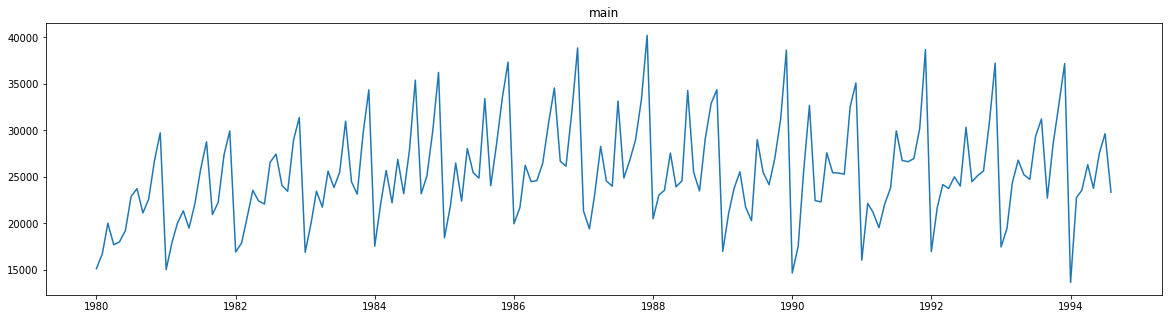

In [37]:
ts.plot()

### Simple forecast

In [38]:
train_ts, test_ts = ts.train_test_split(train_start='1980-01-01',
                                        train_end='1993-12-01',
                                        test_start='1994-01-01',
                                        test_end='1994-08-01')

In [39]:
HORIZON = 8

model = NaiveModel(lag=12)
model.fit(train_ts)

future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)

In [40]:
smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'main': 11.492045838249387}

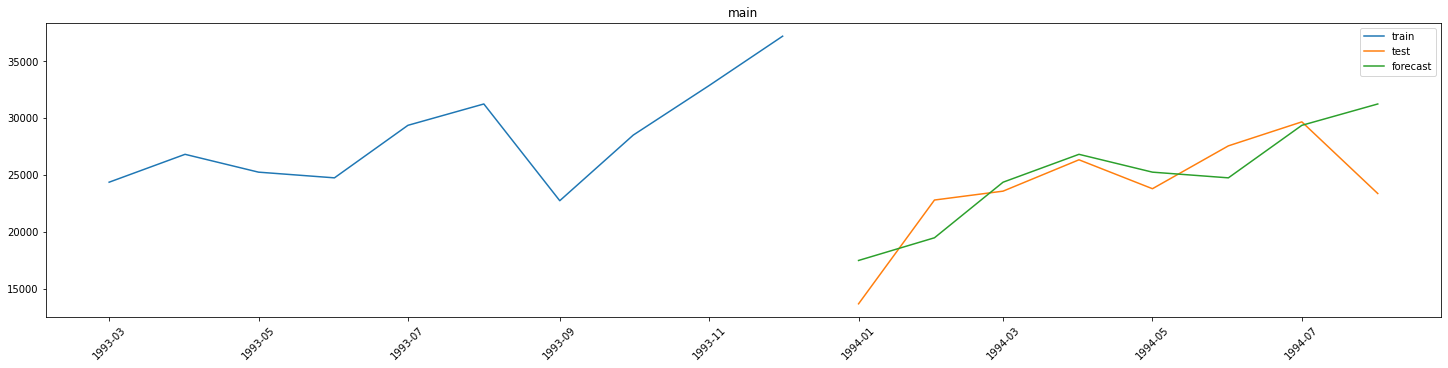

In [41]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

### Prophet

In [42]:
model = ProphetModel()
model.fit(train_ts)

future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [43]:
smape(y_true=test_ts, y_pred=forecast_ts)

{'main': 10.58066231742403}

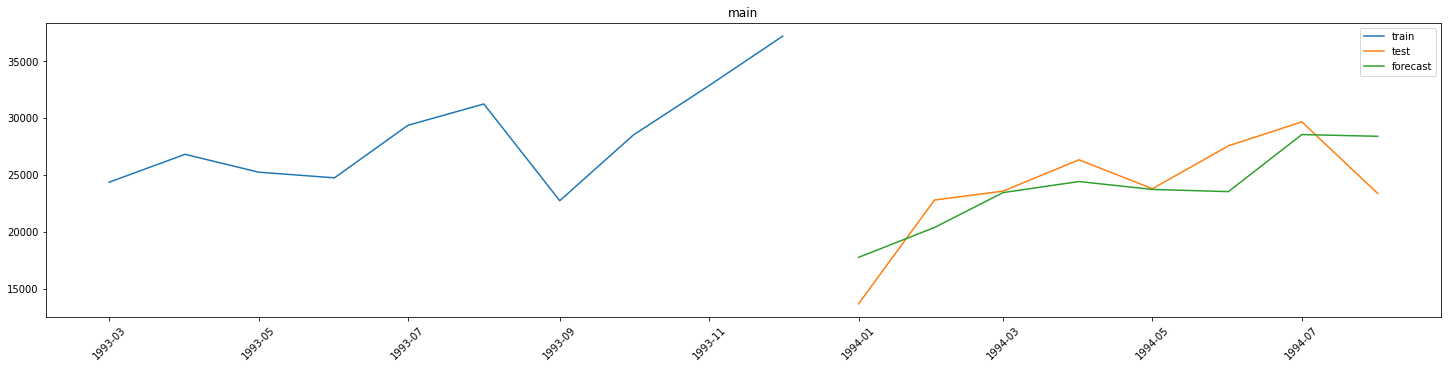

In [44]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

### Catboost

In [45]:
lags = LagTransform(in_column="target", lags=list(range(8, 24, 1)))
train_ts.fit_transform([lags])

In [46]:
model = CatBoostModelMultiSegment()
model.fit(train_ts)
future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)

In [47]:
smape(y_true=test_ts, y_pred=forecast_ts)

{'main': 10.616002875062325}

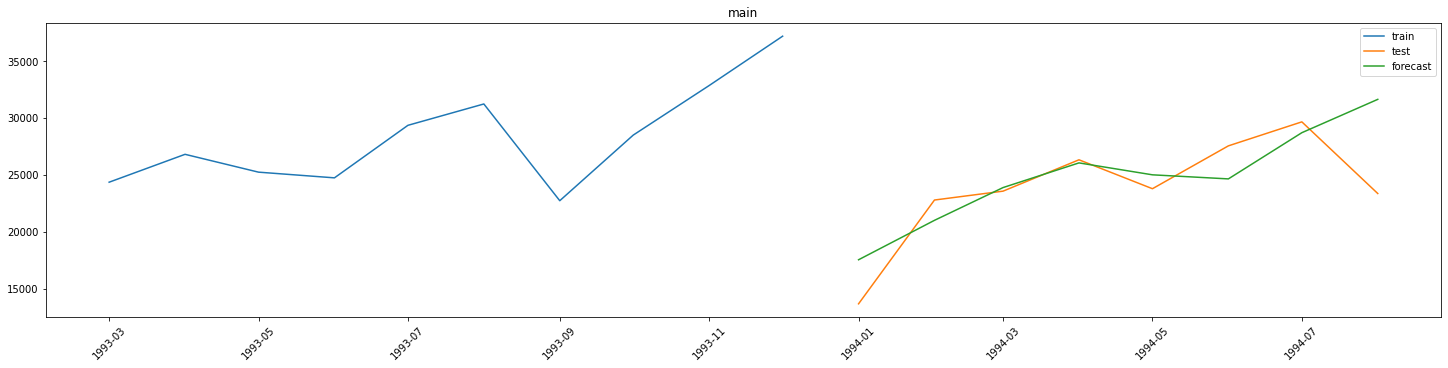

In [48]:
train_ts.inverse_transform()
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

### Forecasting multiple time series

In [49]:
original_df = pd.read_csv("./data/example_dataset.csv", parse_dates=['timestamp'], date_parser=dateparse)
print(original_df.head())
print("----------------")
print(original_df.info())

   timestamp    segment  target
0 2019-01-01  segment_a     170
1 2019-01-02  segment_a     243
2 2019-01-03  segment_a     267
3 2019-01-04  segment_a     287
4 2019-01-05  segment_a     279
----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  1460 non-null   datetime64[ns]
 1   segment    1460 non-null   object        
 2   target     1460 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 34.3+ KB
None


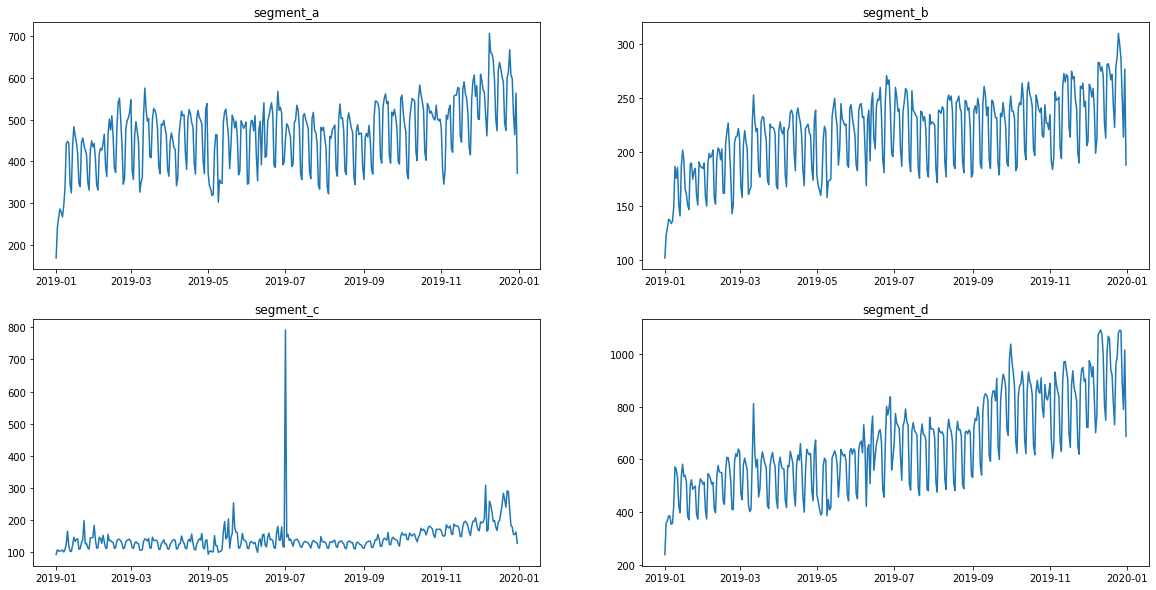

In [50]:
df = TSDataset.to_dataset(original_df)
ts = TSDataset(df, freq='D')
ts.plot()

In [51]:
log = LogTransform(in_column="target")
trend = LinearTrendTransform(in_column="target")
seg = SegmentEncoderTransform()

lags = LagTransform(in_column="target", lags=list(range(30, 96, 1)))
d_flags = DateFlagsTransform(day_number_in_week=True,
                             day_number_in_month=True,
                             week_number_in_month=True,
                             week_number_in_year=True,
                             month_number_in_year=True,
                             year_number=True,
                             special_days_in_week=[5, 6])
mean30 = MeanTransform(in_column="target", window=30)

In [52]:
HORIZON = 31
train_ts, test_ts = ts.train_test_split(train_start='2019-01-01',
                                        train_end='2019-11-30',
                                        test_start='2019-12-01',
                                        test_end='2019-12-31')
train_ts.fit_transform([log, trend, lags, d_flags, seg, mean30])

In [53]:
model = CatBoostModelMultiSegment()
model.fit(train_ts)
future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)

In [54]:
smape(y_true=test_ts, y_pred=forecast_ts)

{'segment_a': 10.692579664240109,
 'segment_b': 6.268086694926161,
 'segment_c': 20.602381827297762,
 'segment_d': 8.863285227901798}

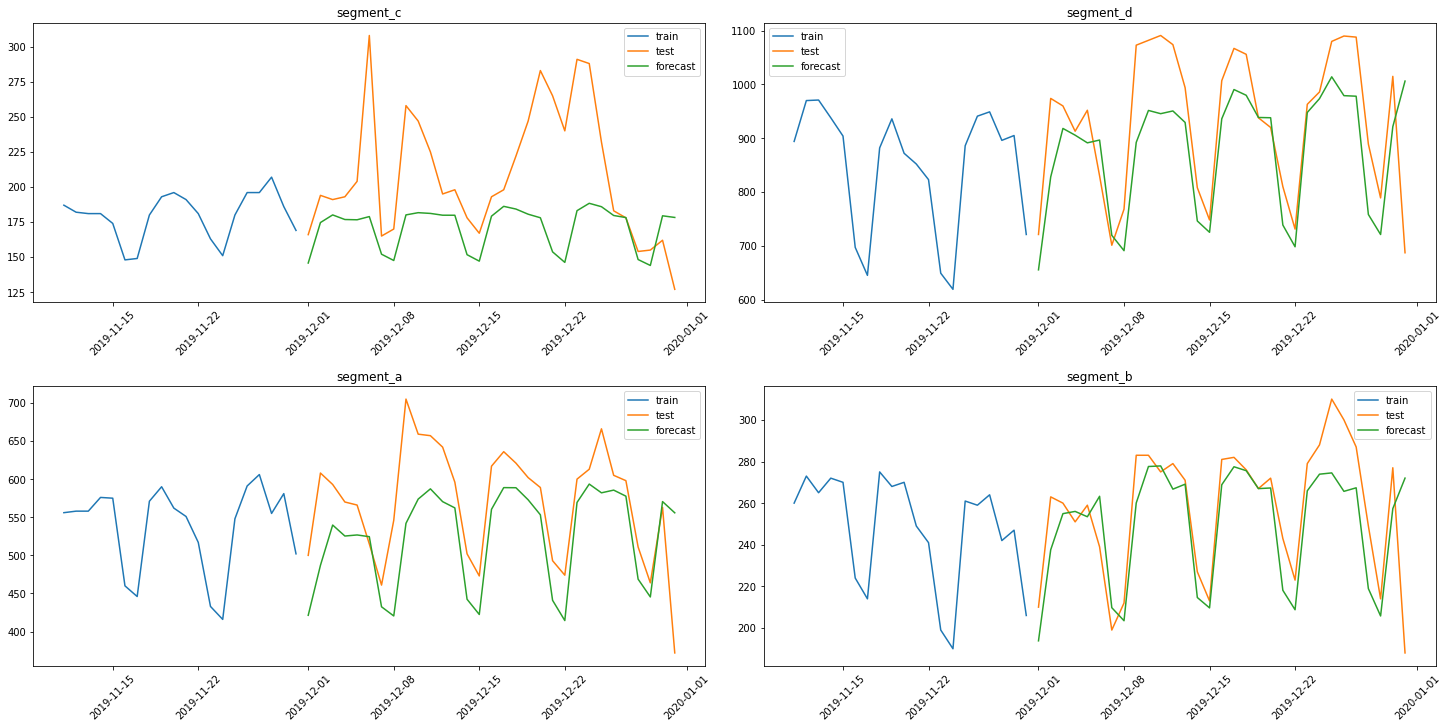

In [55]:
train_ts.inverse_transform()
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=20)

### Pipeline

In [56]:
train_ts, test_ts = ts.train_test_split(train_start='2019-01-01',
                                        train_end='2019-11-30',
                                        test_start='2019-12-01',
                                        test_end='2019-12-31')

In [57]:
model = Pipeline(model=CatBoostModelMultiSegment(),
                transforms=[log, trend, lags, d_flags, seg, mean30],
                horizon=HORIZON)
model.fit(train_ts)
forecast_ts = model.forecast()

In [58]:
smape(y_true=test_ts, y_pred=forecast_ts)

{'segment_a': 10.692579664240109,
 'segment_b': 6.268086694926161,
 'segment_c': 20.602381827297762,
 'segment_d': 8.863285227901798}

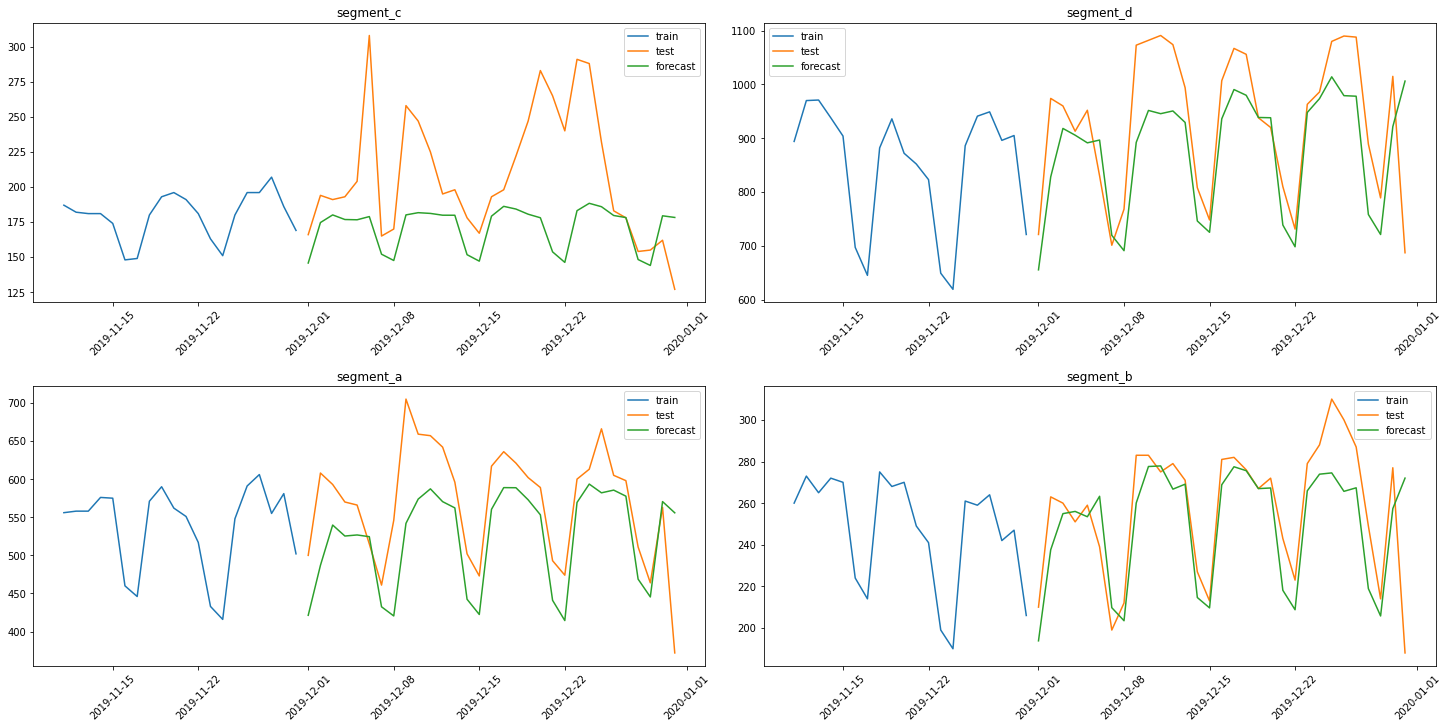

In [59]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=20)